# **FINAL PROJECT NOTEBOOK**
This notebook is a collection of three different components which are aimed to predict the category of a 401(K) investment company, based on the form given as the input.

**Input:-** Form of the investment company (*PDF FORMAT*)

**Output:-** *Category* ['Charles Schwab', 'Merrill Lynch', 'American Trade'..........]


### **<------------------Upload PDF------------------>**

**Make sure you name your PDF as "form.pdf" before uploading.**

In [34]:
pip install pdf2jpg

In [1]:
from io import StringIO
from google.colab import files
uploaded = files.upload()


Saving form.pdf to form.pdf


**PDF PATH**

In [0]:
PDF_PATH = '/content/form.pdf'

In [0]:
from pdf2jpg import pdf2jpg
inputpath = PDF_PATH
outputpath = "/content"
# To convert single page
result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, pages="0")


**IMAGE PATH**

In [0]:
IMAGE_PATH = '/content/form.pdf_dir/0_form.pdf.jpg'

Populating the interactive namespace from numpy and matplotlib


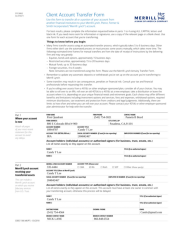


SUCCESSFULLY CONVERTED PDF INTO JPG !


In [5]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(IMAGE_PATH)
imgplot = plt.imshow(img)
axis('off')
plt.show()

print()
print("SUCCESSFULLY CONVERTED PDF INTO JPG !")

## **LOGO AND TYPE DETECTION (*OBJECT DETECTION*)**
In this part of the Notebook, the converted JPEG file is given as the input and using the principles of object detection and using the YOLOV3 Framework, we predict the *name of the company* and the *type of form*.

**Input:-** JPEG FILE

**Output:-** *Category* ['Merrill Lynch', 'Charles Schwab'.......]  *Type* ['IRA, Client Account Transfer Form'] 

In [0]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import utils

In [0]:
config_path='/content/drive/My Drive/config/yolov3.cfg'
weights_path='/content/drive/My Drive/config/checkpoints19.weights'
class_path='/content/drive/My Drive/config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.189642


<Figure size 432x288 with 0 Axes>

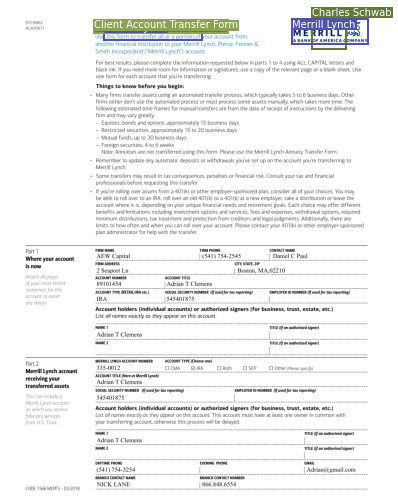


Company Name:-  Merrill Lynch
Type of Form:-  Client Account Transfer Form


In [0]:
# load image and get detections
img_path = IMAGE_PATH
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
k=[]
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        k.append(classes[int(cls_pred)])
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()
if len(k)==5:
  if(k[2] == 'Merrill Lynch' and k[3]== 'Merrill Lynch'):

    print()
    print("Company Name:- ", k[2])
    print("Type of Form:- ", k[4])
else:
  print("Company Name:- ", k[0])
  print("Type of Form:- ", k[1])

## **Named Entity Recognition [NER]**
Using the concepts of NER and OCR, we detect the text element fields in the form and then predict the category, type, and various other fields which are filled in the form.

**Input:-** *FORM* [PDF/JPEG/PNG]

**Output:-** *Category* ['Merrill Lynch', 'Charles Schwab'.......] *Type* ['IRA, Client Account Transfer Form'].......*Name*['Jacobs'....], *City*['New York'....]

In [8]:
!pip install pytesseract

In [9]:
!pip install tesseract

In [10]:
!pip install Pillow

In [11]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [12]:
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
libpoppler-cpp-dev is already the newest version (0.62.0-2ubuntu2.10).
python3-dev is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [13]:
!pip install pdftotext

In [0]:
import pdftotext
import re
import pandas as pd
import os
import glob
import json

In [0]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text


In [0]:
def pdf_core(filename):
    
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
    return "\n\n".join(pdf)
    

**Creating NER Tags**

In [0]:
def extension_type_process(extension,f):
  if extension == 'pdf':
    return pdf_core(f)
  elif extension == 'png':
    return ocr_core(f)

In [0]:
def find_start_end(labelcontent,text,label,category):
  annolist = []

  
  if label == 'CATEGORY':
    if category == 'Merrilllynch_CRA':
      text = 'Merrill Lynch'
    elif category == 'Schwab_IRA':
      text = 'Schwab'
    for match in re.finditer(text, labelcontent):
      annolist.append({"label":[label],"points":[{"start":match.start(),"end":match.end(),"text":text}]})
  elif label == 'PHONE':
    num = "("+text[0:3]+") "+text[3:6]+"-"+text[6:10]
    for match in re.finditer(r'\(\w{3}\) \w{3}-\w{4}', labelcontent):
      if labelcontent[match.start():match.end()] == num:
        annolist.append({"label":[label],"points":[{"start":match.start(),"end":match.end(),"text":num}]})
  elif label == 'CITY':
    city = text.split(',')[0]
    for match in re.finditer(city, labelcontent):
      annolist.append({"label":[label],"points":[{"start":match.start(),"end":match.end(),"text":city}]})
  elif label == 'EMAIL':
    for match in re.finditer(r'[\w\.-]+@[\w\.-]+', labelcontent):
      if labelcontent[match.start():match.end()] == text:
        annolist.append({"label":[label],"points":[{"start":match.start(),"end":match.end(),"text":text}]})
  else:
    for match in re.finditer(text, labelcontent):
      annolist.append({"label":[label],"points":[{"start":match.start(),"end":match.end(),"text":text}]})
  return annolist

In [0]:
def pdf_tag(file,category,filename,df):
    if category == 'Ameritrade Institutional':
      labels = ['CATEGORY','TITLE','CLIENT','ADDRESS','SOCIAL SECURITY NO','RELATIONSHIP NO.','ACC NO','ACC TYPE','PHONE']
    else:
      labels = ['CATEGORY','TITLE','CLIENT','ADDRESS','SOCIAL SECURITY NO','RELATIONSHIP NO.','ACC NO','ACC TYPE','PHONE','CITY','EMAIL']
    dict={}
    annolist = []
    content = pdf_core(file)
    
    dict['content'] = content
    for label in labels:
      result = df[(df['CATEGORY']==category) & (df['FILE NAME']==filename)][label]
      if (list(result) == []):
        continue
      else:
        text=str(result.values[0]).strip()
        annolist = annolist + find_start_end(content,text,label,category)
     
    dict['annotation'] = annolist
    
    return json.dumps(dict)


In [0]:
def png_tag(file,category,filename,df):
    labels = ['CATEGORY','TITLE','CLIENT','ADDRESS','SOCIAL SECURITY NO','RELATIONSHIP NO.','ACC NO','ACC TYPE','PHONE','CITY','EMAIL']
    dict={}
    annolist = []
    content = ocr_core(file)
    dict['content'] = content
    for label in labels:
      result = df[(df['CATEGORY']==category) & (df['FILE NAME']==filename)][label]
      if (list(result) == []):
        continue
      else:
        text=str(result.values[0]).strip()
        annolist = annolist + find_start_end(content,text,label,category)
    dict['annotation'] = annolist
    
    return json.dumps(dict)


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("/content/drive/My Drive/DOC-NER/IRA.csv")

In [0]:
categories = ['Merrilllynch_CRA','Schwab_IRA','Ameritrade Institutional']
pdf_doc_dict={}
png_doc_dict={}
for company in categories:
  fullpath = "/content/drive/My Drive/DOC-NER/"+company
  os.chdir(fullpath)
  all_filenames = [i for i in glob.glob('*.{}'.format('pdf'))]
  pdf_doc_dict[company] = [pdf_tag(f,company,f.split('.')[0],df) for f in all_filenames ]
  all_filenames = [i for i in glob.glob('*.{}'.format('png'))]
  png_doc_dict[company] = [png_tag(f,company,f.split('.')[0],df) for f in all_filenames ]


In [24]:
list(png_doc_dict.values())[0]

['{"content": "DTC8862\\nACATO671\\n\\nClient Account Transfer Form\\n\\nUse this form to transfer all or a portion of your account from\\nanother financial institution to your Merrill Lynch, Pierce, Fenner &\\nSmith Incorporated (\\u201cMerrill Lynch\\u201d) account.\\n\\nMERRILL bos\\n\\nA BANK OF AMERICA COMPANY\\n\\nFor best results, please complete the information requested below in parts 1 to 4 using ALL CAPITAL letters and\\nblack ink. If you need more room for information or signatures, use a copy of the relevant page or a blank sheet. Use\\none form for each account that you\'re transferring.\\n\\nThings to know before you begin:\\n\\nMany firms transfer assets using an automated transfer process, which typically takes 5 to 6 business days. Other\\nfirms either don\\u2019t use the automated process or must process some assets manually, which takes more time. The\\nfollowing estimated time frames for manual transfers are from the date of receipt of instructions by the deliverin

In [0]:
os.chdir("/content/drive/My Drive/DOC-NER/")
with open('testfile.txt', 'w') as filehandle:
  for category, tagtext in png_doc_dict.items():
    if len(tagtext) != 0:
      for listitem in tagtext:
        filehandle.write('%s\n' % listitem)
  for category, tagtext in pdf_doc_dict.items():
    if len(tagtext) != 0:
      for listitem in tagtext:
        filehandle.write('%s\n' % listitem)      

**Model Training**

In [0]:
import json
import random
import logging
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from sklearn.metrics import accuracy_score
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:
                point = annotation['points'][0]
                labels = annotation['label']
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    entities.append((point['start'], point['end'] + 1 ,label))


            training_data.append((text, {"entities" : entities}))

        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None


In [4]:
import spacy
def train_spacy():

    TRAIN_DATA = convert_dataturks_to_spacy("/content/drive/My Drive/DOC-NER/train.txt")
    nlp = spacy.blank('en')  
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  
        optimizer = nlp.begin_training()
        for itn in range(10):
            print("Statring iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  
                    [annotations],  
                    drop=0.2,  
                    sgd=optimizer,  
                    losses=losses)
            print(losses)
    return nlp

nlp = train_spacy()

NameError: ignored

In [28]:
    examples = convert_dataturks_to_spacy("/content/drive/My Drive/DOC-NER/validate.txt")
    tp=0
    tr=0
    tf=0

    ta=0
    c=0        
    for text,annot in examples:

        f=open("doc"+str(c)+".txt","w")
        doc_to_test=nlp(text)
        
        d={}
        for ent in doc_to_test.ents:
            d[ent.label_]=[]
        for ent in doc_to_test.ents:
            d[ent.label_].append(ent.text)

        for i in set(d.keys()):
            f.write("\n\n")
            f.write(i +":"+"\n")
            for j in set(d[i]):
                f.write(j.replace('\n','')+"\n")
        d={}
        for ent in doc_to_test.ents:
            d[ent.label_]=[0,0,0,0,0,0]
        for ent in doc_to_test.ents:
            doc_gold_text= nlp.make_doc(text)
            gold = GoldParse(doc_gold_text, entities=annot.get("entities"))
            y_true = [ent.label_ if ent.label_ in x else 'Not '+ent.label_ for x in gold.ner]
            y_pred = [x.ent_type_ if x.ent_type_ ==ent.label_ else 'Not '+ent.label_ for x in doc_to_test]  
            if(d[ent.label_][0]==0):
                
                (p,r,f,s)= precision_recall_fscore_support(y_true,y_pred,average='weighted')
                a=accuracy_score(y_true,y_pred)
                d[ent.label_][0]=1
                d[ent.label_][1]+=p
                d[ent.label_][2]+=r
                d[ent.label_][3]+=f
                d[ent.label_][4]+=a
                d[ent.label_][5]+=1
        c+=1
    
    for i in d:
        print("\n For Entity "+i+"\n")
        print("Accuracy : "+str((d[i][4]/d[i][5])*100)+"%")
        print("Precision : "+str(d[i][1]/d[i][5]))
        print("Recall : "+str(d[i][2]/d[i][5]))
        print("F-score : "+str(d[i][3]/d[i][5]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 For Entity ACC TYPE

Accuracy : 100.0%
Precision : 1.0
Recall : 1.0
F-score : 1.0

 For Entity CATEGORY

Accuracy : 98.21948296524567%
Precision : 0.9958105481535193
Recall : 0.9821948296524567
F-score : 0.9876255413655719

 For Entity TITLE

Accuracy : 100.0%
Precision : 1.0
Recall : 1.0
F-score : 1.0


In [3]:
def predict(filepath,type,output_filename,nlp):
        f=open(output_filename,"w")
        doc_to_test=""
        if type=='pdf':
          doc_to_test=nlp(pdf_core(filepath))
        elif type=='png':
          doc_to_test=nlp(ocr_core(filepath))
        d={}
        for ent in doc_to_test.ents:
            d[ent.label_]=[]
        for ent in doc_to_test.ents:
            d[ent.label_].append(ent.text)

        for i in set(d.keys()):
            print("\n\n")
            print(i +":"+"\n")
            for j in set(d[i]):
                print(j.replace('\n','')+"\n")

predict(PDF_PATH,'pdf','predict.txt',nlp)

NameError: ignored

In [24]:
def predict(filepath,type,output_filename,nlp):
        f=open(output_filename,"w")
        doc_to_test=""
        if type=='pdf':
          doc_to_test=nlp(pdf_core(filepath))
        elif type=='png':
          doc_to_test=nlp(ocr_core(filepath))
        d={}
        for ent in doc_to_test.ents:
            d[ent.label_]=[]
        for ent in doc_to_test.ents:
            d[ent.label_].append(ent.text)

        for i in set(d.keys()):
            print("\n\n")
            print(i +":"+"\n")
            for j in set(d[i]):
                print(j.replace('\n','')+"\n")

predict('/content/drive/My Drive/DOC-NER/Schwab_IRA/James_B_Adams_.pdf','pdf','predict.txt',nlp)




CITY:

3021              

Schwab Traditional




TITLE:

Account Application.




CATEGORY:

Schwab.

Schwab                                                                     

Schwab research

Schwab                                                             

Schwab)

Schwab is

Schwab                         

Schwab           

Schwab any

Schwab has

Schwab will

Schwab

Schwab,

Schwab (

Schwab Bank)

Schwab may

Schwab or

Schwab                            

Schwab                     

Schwab changes

Schwab Bank High

Schwab Bank

Schwab Alliance

Schwab Private

Schwab Profit

Schwab Traditional

Schwab IRA

Schwab;

Schwab          

Schwab:

Schwab”

Schwab Bank using

Schwab Bank accounts

Schwab Bank,




ACC TYPE:

IRA;

IRA                 

IRA.

IRA)

IRA		

IRAs



## **TEXT CLASSIFICATION/ ANALYSIS USING [LSTM (Long Short Term Memory)]**
In this final step we perform, sentiment analysis over the text, saved in an CSV File, using the LSTM Architecture to predict the category of the form (i.e the company to which the form belongs).

**Input:-** Results from NER

**Output:-** *Category* ['Merrill Lynch', 'Charles Schwab'.......] 

In [0]:
import pandas as pd
import numpy as np


In [26]:
from io import StringIO
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [0]:
path = '/content/IRA.csv'

In [0]:
df = pd.read_csv(path, encoding = 'unicode_escape')

In [0]:
df = pd.read_csv(path, encoding = 'unicode_escape')

In [0]:
import torch
from torchtext import data

In [0]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField()

In [0]:
fields = [('sl', TEXT), ('category', LABEL), ('file_name', TEXT), ('file_size', TEXT), ('title', TEXT), ('file_desc', TEXT), ('client', TEXT), ('address', TEXT), ('social_number', TEXT), ('merrill_no', TEXT), ('acc_no', TEXT), ('acc_type', TEXT), ('phone', TEXT), ('city', TEXT), ('email', TEXT)]

In [0]:
news = data.TabularDataset(
    path='IRA.csv', format='csv',
    fields = fields,
    skip_header= True)


In [0]:
import random
SEED = 1234

trn, vld, tst = news.split(split_ratio=[0.7, 0.2, 0.1], random_state = random.seed(SEED))

In [0]:
vars(trn[0])     

In [0]:
TEXT.build_vocab(trn, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [0]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))

In [0]:
print(LABEL.vocab.stoi)

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trn, vld, tst), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key= lambda x:x.client, 
    sort_within_batch= False
    )

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm_fn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_fs = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_title = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_fdesc = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_head = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_desc = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)

       ## Social security number(ssn)
        ## Relationship NUmber
        self.lstm_ssn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_mn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_acn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_act = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_phone = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_city = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        self.lstm_email = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)

        self.fc_fn = nn.Linear(hidden_dim * 2, 100)
        self.fc_fs = nn.Linear(hidden_dim * 2, 100)
        self.fc_title = nn.Linear(hidden_dim * 2, 100)
        self.fc_fdesc = nn.Linear(hidden_dim * 2, 100)
        self.fc_head = nn.Linear(hidden_dim * 2, 100)
        self.fc_desc = nn.Linear(hidden_dim * 2, 100)
        self.fc_ssn = nn.Linear(hidden_dim * 2, 100)
        self.fc_mn = nn.Linear(hidden_dim * 2, 100)
        self.fc_acn = nn.Linear(hidden_dim * 2, 100)
        self.fc_act = nn.Linear(hidden_dim * 2, 100)
        self.fc_phone = nn.Linear(hidden_dim * 2, 100)
        self.fc_city = nn.Linear(hidden_dim * 2, 100)
        self.fc_email = nn.Linear(hidden_dim * 2, 100)

        self.fc_total = nn.Linear(1300, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, file_name, file_size, title, file_desc, headline, description, social_number, merrill_no, acc_no, acc_type, phone, city, email):
                        
        embedded_fn = self.dropout(self.embedding(file_name))
        embedded_fs = self.dropout(self.embedding(file_size))
        embedded_title = self.dropout(self.embedding(title))
        embedded_fdesc = self.dropout(self.embedding(file_desc))
        embedded_head = self.dropout(self.embedding(headline))
        embedded_desc= self.dropout(self.embedding(description))
        embedded_ssn = self.dropout(self.embedding(social_number))
        embedded_mn = self.dropout(self.embedding(merrill_no))
        embedded_acn = self.dropout(self.embedding(acc_no))
        embedded_act = self.dropout(self.embedding(acc_type))
        embedded_phone = self.dropout(self.embedding(phone))
        embedded_city = self.dropout(self.embedding(city))
        embedded_email = self.dropout(self.embedding(email))
                                    
        output_fn, (hidden_fn, cell_fn) = self.lstm_fn(embedded_fn)
        output_fs, (hidden_fs, cell_fs) = self.lstm_fs(embedded_fs)
        output_title, (hidden_title, cell_title) = self.lstm_title(embedded_title)
        output_fdesc, (hidden_fdesc, cell_fdesc) = self.lstm_fdesc(embedded_fdesc)
        output_head, (hidden_head, cell_head) = self.lstm_head(embedded_head)
        output_desc, (hidden_desc, cell_desc) = self.lstm_desc(embedded_desc)
        output_ssn, (hidden_ssn, cell_ssn) = self.lstm_ssn(embedded_ssn)
        output_mn, (hidden_mn, cell_mn) = self.lstm_mn(embedded_mn)
        output_acn, (hidden_acn, cell_acn) = self.lstm_acn(embedded_acn)
        output_act, (hidden_act, cell_act) = self.lstm_act(embedded_act)
        output_phone, (hidden_phone, cell_phone) = self.lstm_phone(embedded_phone)
        output_city, (hidden_city, cell_city) = self.lstm_city(embedded_city)
        output_email, (hidden_email, cell_email) = self.lstm_email(embedded_email)
   
        hidden_fn = self.dropout(torch.cat((hidden_fn[-2, :, :], hidden_fn[-1, :, :]), dim = 1))
        hidden_fs = self.dropout(torch.cat((hidden_fs[-2, :, :], hidden_fs[-1, :, :]), dim = 1))
        hidden_title = self.dropout(torch.cat((hidden_title[-2, :, :], hidden_title[-1, :, :]), dim = 1))
        hidden_fdesc = self.dropout(torch.cat((hidden_fdesc[-2, :, :], hidden_fdesc[-1, :, :]), dim = 1))
        hidden_head = self.dropout(torch.cat((hidden_head[-2, :, :], hidden_head[-1, :, :]), dim = 1))
        hidden_desc = self.dropout(torch.cat((hidden_desc[-2, :, :], hidden_desc[-1, :, :]), dim = 1))
        hidden_ssn = self.dropout(torch.cat((hidden_ssn[-2, :, :], hidden_ssn[-1, :, :]), dim = 1))
        hidden_mn = self.dropout(torch.cat((hidden_mn[-2, :, :], hidden_mn[-1, :, :]), dim = 1))
        hidden_acn = self.dropout(torch.cat((hidden_acn[-2, :, :], hidden_acn[-1, :, :]), dim = 1))
        hidden_act = self.dropout(torch.cat((hidden_act[-2, :, :], hidden_act[-1, :, :]), dim = 1))
        hidden_phone = self.dropout(torch.cat((hidden_phone[-2, :, :], hidden_phone[-1, :, :]), dim = 1))
        hidden_city = self.dropout(torch.cat((hidden_city[-2, :, :], hidden_city[-1, :, :]), dim = 1))
        hidden_email = self.dropout(torch.cat((hidden_email[-2, :, :], hidden_email[-1, :, :]), dim = 1))

        
               
        full_fn = self.fc_fn(hidden_fn)
        full_fs = self.fc_fs(hidden_fs)
        full_title = self.fc_title(hidden_title)
        full_fdesc = self.fc_fdesc(hidden_fdesc)
        full_head = self.fc_head(hidden_head)
        full_desc = self.fc_desc(hidden_desc)
        full_ssn = self.fc_ssn(hidden_ssn)
        full_mn = self.fc_mn(hidden_mn)
        full_acn = self.fc_acn(hidden_acn)
        full_act = self.fc_act(hidden_act)
        full_phone = self.fc_phone(hidden_phone)
        full_city = self.fc_city(hidden_city)
        full_email = self.fc_email(hidden_email)

               
        hidden_total = torch.cat((full_fn, full_fs, full_title, full_fdesc, full_head, full_desc, full_ssn, full_mn, full_acn, full_act, full_phone, full_city, full_email), 1)
        
        return self.fc_total(hidden_total)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [0]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

In [0]:
model.embedding.weight.data.copy_(pretrained_embeddings)

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True)
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                        
        predictions = model(batch.file_name, batch.file_size, batch.title, batch.file_desc, batch.client, batch.address, batch.social_number, batch.merrill_no, batch.acc_no, batch.acc_type, batch.phone, batch.city, batch.email).squeeze(1)
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            predictions = model(batch.file_name, batch.file_size, batch.title, batch.file_desc, batch.client, batch.address, batch.social_number, batch.merrill_no, batch.acc_no, batch.acc_type, batch.phone, batch.city, batch.email).squeeze(1) 
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.client)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [0]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'news_classification_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [0]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [0]:
import spacy
nlp = spacy.load('en')

def predict_category(model, file_name, file_size, title, file_desc, head, desc, ssn, mn, acn, act, phone, city, email):
    model.eval()
    file_name = file_name.lower()
    file_size = file_size.lower()
    title = title.lower()
    file_desc = file_desc.lower()
    head = head.lower()
    desc = desc.lower()
    ssn = ssn.lower()
    mn = mn.lower()
    acn = acn.lower()
    act = act.lower()
    phone = phone.lower()
    city = city.lower()
    email = email.lower()
   

    tokenized_file_name = [tok.text for tok in nlp.tokenizer(file_name)]
    tokenized_file_size = [tok.text for tok in nlp.tokenizer(file_size)]
    tokenized_title = [tok.text for tok in nlp.tokenizer(title)]
    tokenized_file_desc = [tok.text for tok in nlp.tokenizer(file_desc)]
    tokenized_head = [tok.text for tok in nlp.tokenizer(head)]
    tokenized_desc = [tok.text for tok in nlp.tokenizer(desc)]
    tokenized_ssn = [tok.text for tok in nlp.tokenizer(ssn)]
    tokenized_mn = [tok.text for tok in nlp.tokenizer(mn)]
    tokenized_acn = [tok.text for tok in nlp.tokenizer(acn)]
    tokenized_act = [tok.text for tok in nlp.tokenizer(act)]
    tokenized_phone = [tok.text for tok in nlp.tokenizer(phone)]
    tokenized_city = [tok.text for tok in nlp.tokenizer(city)]
    tokenized_email = [tok.text for tok in nlp.tokenizer(email)]
   
    indexed_file_name = [TEXT.vocab.stoi[t] for t in tokenized_file_name]
    indexed_file_size = [TEXT.vocab.stoi[t] for t in tokenized_file_size]
    indexed_title = [TEXT.vocab.stoi[t] for t in tokenized_title]
    indexed_file_desc = [TEXT.vocab.stoi[t] for t in tokenized_file_desc]
    indexed_head = [TEXT.vocab.stoi[t] for t in tokenized_head]
    indexed_desc = [TEXT.vocab.stoi[t] for t in tokenized_desc]
    indexed_ssn = [TEXT.vocab.stoi[t] for t in tokenized_ssn]
    indexed_mn = [TEXT.vocab.stoi[t] for t in tokenized_mn]
    indexed_acn = [TEXT.vocab.stoi[t] for t in tokenized_acn]
    indexed_act = [TEXT.vocab.stoi[t] for t in tokenized_act]
    indexed_phone = [TEXT.vocab.stoi[t] for t in tokenized_phone]
    indexed_city = [TEXT.vocab.stoi[t] for t in tokenized_city]
    indexed_email = [TEXT.vocab.stoi[t] for t in tokenized_email]

    
    tensor_file_name = torch.LongTensor(indexed_file_name).to(device)
    tensor_file_size = torch.LongTensor(indexed_file_size).to(device)
    tensor_title = torch.LongTensor(indexed_title).to(device)
    tensor_file_desc= torch.LongTensor(indexed_file_desc).to(device)
    tensor_head = torch.LongTensor(indexed_head).to(device)
    tensor_desc = torch.LongTensor(indexed_desc).to(device)
    tensor_ssn = torch.LongTensor(indexed_ssn).to(device)
    tensor_mn = torch.LongTensor(indexed_mn).to(device)
    tensor_acn = torch.LongTensor(indexed_acn).to(device)
    tensor_act = torch.LongTensor(indexed_act).to(device)
    tensor_phone = torch.LongTensor(indexed_phone).to(device)
    tensor_city = torch.LongTensor(indexed_city).to(device)
    tensor_email = torch.LongTensor(indexed_email).to(device)

    
    tensor_file_name = tensor_file_name.unsqueeze(1)
    tensor_file_size = tensor_file_size.unsqueeze(1)
    tensor_title = tensor_title.unsqueeze(1)
    tensor_file_desc = tensor_file_desc.unsqueeze(1)
    tensor_head = tensor_head.unsqueeze(1)
    tensor_desc = tensor_desc.unsqueeze(1)
    tensor_ssn = tensor_ssn.unsqueeze(1)
    tensor_mn = tensor_mn.unsqueeze(1)
    tensor_acn = tensor_acn.unsqueeze(1)
    tensor_act = tensor_act.unsqueeze(1)
    tensor_phone = tensor_phone.unsqueeze(1)
    tensor_city = tensor_city.unsqueeze(1)
    tensor_email = tensor_email.unsqueeze(1)

    prediction = model(tensor_file_name, tensor_file_size, tensor_title, tensor_file_desc, tensor_head, tensor_desc, tensor_ssn, tensor_mn, tensor_acn, tensor_act, tensor_phone, tensor_city, tensor_email)
    max_pred = prediction.argmax(dim=1)
    return max_pred.item()

In [0]:
pred = predict_category(model, "Adrian Clemens", "298 KB", "Client Account Transfer Form", "Use this form to transfer all or a portion of your account from another financial institution to your Merrill Lynch, Pierce, Fenner & Smith Incorporated (“Merrill Lynch”) account.", "Daniel C Paul", "2 Seaport Ln", "545401875", "3350012", "89101454", "IRA", "5417542545", "Boston, MA,02210", "Adrian@gmail.com" )
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

# By:- Saksham Dubey and Satish Patnaik, 
# Under the guidance and supervision of **Mr. Sheik Dawood**